### Replication of the [article](https://arxiv.org/abs/2010.11929) and integration with the food101 images 

In [3]:
from typing import Dict, List, Tuple
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from modular_classification import (data_setup, 
                                    engine)
from modular_classification.engine import (test_func,
                                           train_func )                                
import torchinfo
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from datetime import datetime

/home/astolfo/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def set_seed(seed: int=23):
    """
    Sets a specific seed for the tests
    
    Args:
        seed (int, optional): Random seed to set. Defaults is 23.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [6]:
test_dir= "./datasets/pizza_sushi/test"
train_dir = "./datasets/pizza_sushi/train"

Base on the hyperparameter of the article we need to rezise the images to 224x224

In [7]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [8]:
BATCH_SIZE = 32
train_dataloader, test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir
                                                                               , test_dir=test_dir
                                                                                ,transform=manual_transforms,
                                                                                  batch_size=32)
train_dataloader.dataset, test_dataloader.dataset, class_names

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: ./datasets/pizza_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: ./datasets/pizza_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 ['pizza', 'steak', 'sushi'])

Remember that our images are H x W x C, where H is height, W width, and C the channels. \
Adapting the embeding of the model, knowing that **\(N x (P² * C)\)** \
And (P, P) is the patch size, 
Whe can get that **\(N = HW/P²\)**

In a visual representation that embedding is slicing sector's of the images then assigning to a embedding value based on the size og the below formulas

In [16]:
height = 224
width = 224
color_chanels = 3
patch_size = 16 #The article says is the better

number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

So we start with a image and then get a flatten 2d patches in this case with size 196

So how many patches we get? replace the P value in the  **\(N x (P² * C)\)** formula 

In [17]:
embedding_layer_output = (number_of_patches, patch_size ** 2 *color_chanels)
embedding_layer_output

(196, 768)

So we know how many patches a image would have, lets start to doing that

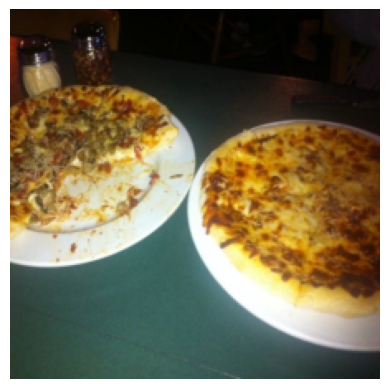

In [11]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
plt.imshow(image.permute(1, 2, 0))
plt.axis(False);

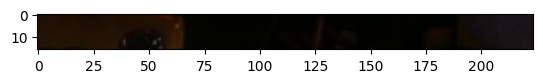

In [13]:
img_permute = image.permute(1, 2, 0)
plt.imshow(img_permute[:patch_size, :, :]);

So we got the 16 first pixels of the image

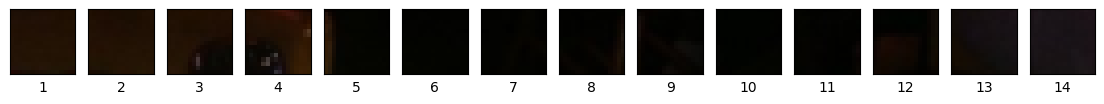

In [20]:
num_patches = int(IMG_SIZE / patch_size)
fig, axs = plt.subplots(nrows=1, ncols=num_patches
                         , figsize=(num_patches, num_patches),
                         sharex=True,
                         sharey=True)
for i, patch in enumerate(range(0, IMG_SIZE, patch_size)):
    axs[i].imshow(img_permute[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Lets iterate over all the image

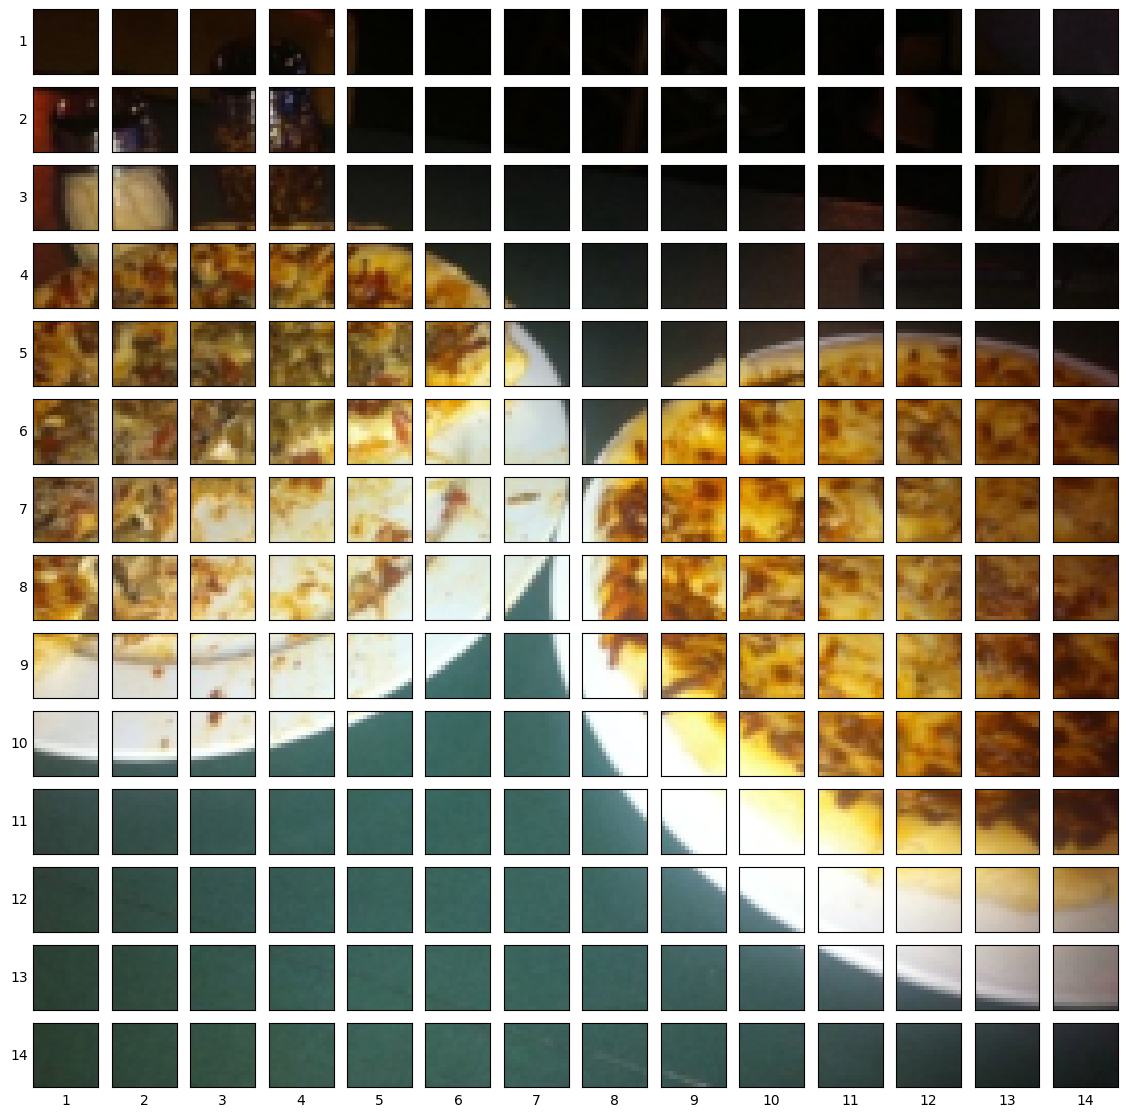

In [22]:
num_patches = int(IMG_SIZE / patch_size)
fig, axs = plt.subplots(nrows=num_patches, ncols=num_patches
                         , figsize=(num_patches, num_patches),
                         sharex=True,
                         sharey=True)
for i, patch_height in enumerate(range(0, IMG_SIZE, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, IMG_SIZE, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(img_permute[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
plt.show()

Lets do the same but with a Conv2d layer

In [23]:
conv2 = nn.Conv2d(3, 768, patch_size, patch_size,0) 
#In this case we use the kernel and stride as the patch size
#Ensure the same effect as before

In [39]:
img_out = conv2(image.unsqueeze(0))
img_out.shape

torch.Size([1, 768, 14, 14])

Lets flatten

In [27]:
flatten = nn.Flatten(2, 3)

In [40]:
img_out = flatten(img_out).permute(2, 1, 0)[:, :, 0]
img_out.shape

torch.Size([196, 768])

Like we calculate earlier